In [ ]:
!pip install hypnettorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.9/456.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = '.'

Reading MNIST dataset ...
Creating directory "./MNIST" ...
Reading labels from ./MNIST/train-labels-idx1-ubyte.gz.
Number of labels in current file: 60000
Reading labels from ./MNIST/t10k-labels-idx1-ubyte.gz.
Number of labels in current file: 10000
Reading images from ./MNIST/train-images-idx3-ubyte.gz.
Number of images in current file: 60000
Reading images from ./MNIST/t10k-images-idx3-ubyte.gz.
Number of images in current file: 10000
Elapsed time to read dataset: 10.182186 sec


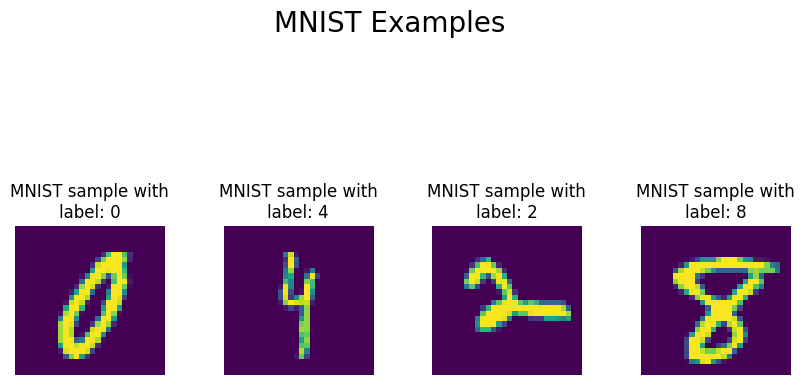

In [ ]:
from hypnettorch.data import MNISTData
mnist = MNISTData(data_dir, use_one_hot=True, validation_size=0)
mnist_inps, mnist_trgts = mnist.next_train_batch(4)
mnist.plot_samples('MNIST Examples', mnist_inps, outputs=mnist_trgts)

In [ ]:
from hypnettorch.mnets import LeNet
mnet = LeNet(in_shape=mnist.in_shape, num_classes=mnist.num_classes,
             arch='mnist_small', no_weights=True).to(device)

Creating a LeNet with 21840 weights.


In [ ]:
from hypnettorch.hnets import HMLP
hnet = HMLP(mnet.param_shapes, uncond_in_size=0, cond_in_size=8,
            layers=[100, 100], num_cond_embs=2).to(device)

print()
print('The randomly initialized input embeddings are:\n', 
      hnet.conditional_params)

# To produce main network weights for condition `0`, we can either pass
# the corresponding condition ID, or the corresponding (internally maintained)
# embedding to the `forward` of the hypernetwork.
W0 = hnet.forward(cond_id=0)
W0_tmp = hnet.forward(cond_input=hnet.conditional_params[0].view(1, -1))
assert np.all([torch.equal(W0[i], W0_tmp[i]) for i in range(len(W0))])

# Hypernetworks also allow batch processing.
W_batch = hnet.forward(cond_id=[0, 0])
assert np.all([torch.equal(W_batch[0][i], W_batch[1][i]) \
               for i in range(len(W0))])

Created MLP Hypernet.
Hypernetwork with 2216856 weights and 21840 outputs (compression ratio: 101.50).
The network consists of 2216840 unconditional weights (2216840 internally maintained) and 16 conditional weights (16 internally maintained).

The randomly initialized input embeddings are:
 [Parameter containing:
tensor([ 0.4891, -0.4851,  0.4709, -0.5650,  0.2966,  0.0513, -0.7459,  0.2384],
       requires_grad=True), Parameter containing:
tensor([-0.3030,  0.5743,  0.7870,  1.6803, -2.0452, -0.6947,  0.0759, -0.3387],
       requires_grad=True)]


In [ ]:
hnet.apply_hyperfan_init(mnet=mnet)

In [ ]:
# Get a batch of main network inputs.
mnist_inps, _ = mnist.next_train_batch(4)
X = mnist.input_to_torch_tensor(mnist_inps, device, mode='train')

# Generate the main network weights for both conditions.
W = hnet.forward(cond_id=[0, 1])

Y0 = mnet.forward(X, weights=W[0])
print('Predicted classes for condition 0: ', Y0.max(dim=1)[1])

Y1 = mnet.forward(X, weights=W[1])
print('Predicted classes for condition 1: ', Y1.max(dim=1)[1])

Predicted classes for condition 0:  tensor([0, 0, 0, 0])
Predicted classes for condition 1:  tensor([6, 6, 6, 6])


In [ ]:
def calc_accuracy(data, mnet, mnet_weights):
    """Compute the test accuracy for a given dataset"""
    with torch.no_grad():
        # Process complete test set as one batch.
        test_in = data.input_to_torch_tensor( \
            data.get_test_inputs(), device, mode='inference')
        test_out = data.input_to_torch_tensor( \
            data.get_test_outputs(), device, mode='inference')
        test_lbls = test_out.max(dim=1)[1]

        logits = mnet(test_in, weights=mnet_weights)
        pred_lbls = logits.max(dim=1)[1]

        acc = torch.sum(test_lbls == pred_lbls) / test_lbls.numel() * 100.

    return acc

# Configure training.
lr=1e-4
batchsize=32
nepochs=10

# Adam usually works well in combination with hypernetwork training.
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(nepochs): # For each epoch.

    # Iterate over the whole MNIST/FashionMNIST training set.
    # Note, that both datasets have the same number of training samples.
    i = 0
    for curr_batchsize, mx, my in mnist.train_iterator(batchsize):
        i += 1

        # Current mini-batch of MNIST samples.
        mnist_X = mnist.input_to_torch_tensor(mx, device, mode='train')
        mnist_Y = mnist.output_to_torch_tensor(my, device, mode='train')

        optimizer.zero_grad()

        # Compute MNIST loss.
        W_mnist = hnet(cond_id=0)
        mnist_P = mnet.forward(mnist_X, weights=W_mnist)
        loss_mnist = criterion(mnist_P, mnist_Y.max(dim=1)[1])
        
        # The total loss is simply each task's loss combined.
        loss = loss_mnist
        loss.backward()
        optimizer.step()

        if i % 500 == 0:            
            print('[%d, %5d] loss: %.3f, MNIST acc: %.2f%%' %
                  (epoch + 1, i + 1, loss.item(), 
                   calc_accuracy(mnist, mnet, W_mnist)))

print('Training finished with test-accs: MNIST acc: %.2f%%' % \
      (calc_accuracy(mnist, mnet, W_mnist)))

[1,   501] loss: 0.098, MNIST acc: 96.34%
[1,  1001] loss: 0.043, MNIST acc: 96.56%
[1,  1501] loss: 0.092, MNIST acc: 97.95%
[2,   501] loss: 0.022, MNIST acc: 98.33%
[2,  1001] loss: 0.014, MNIST acc: 98.59%
[2,  1501] loss: 0.003, MNIST acc: 98.29%
[3,   501] loss: 0.005, MNIST acc: 98.56%
[3,  1001] loss: 0.036, MNIST acc: 98.73%
[3,  1501] loss: 0.013, MNIST acc: 98.71%
[4,   501] loss: 0.003, MNIST acc: 98.67%
[4,  1001] loss: 0.008, MNIST acc: 98.04%
[4,  1501] loss: 0.033, MNIST acc: 98.71%
[5,   501] loss: 0.000, MNIST acc: 98.82%
[5,  1001] loss: 0.017, MNIST acc: 98.86%
[5,  1501] loss: 0.008, MNIST acc: 98.80%
[6,   501] loss: 0.050, MNIST acc: 98.95%
[6,  1001] loss: 0.021, MNIST acc: 99.17%
[6,  1501] loss: 0.002, MNIST acc: 98.70%
[7,   501] loss: 0.010, MNIST acc: 99.01%
[7,  1001] loss: 0.000, MNIST acc: 98.70%
[7,  1501] loss: 0.004, MNIST acc: 98.90%
[8,   501] loss: 0.010, MNIST acc: 99.08%
[8,  1001] loss: 0.017, MNIST acc: 99.08%
[8,  1501] loss: 0.029, MNIST acc:

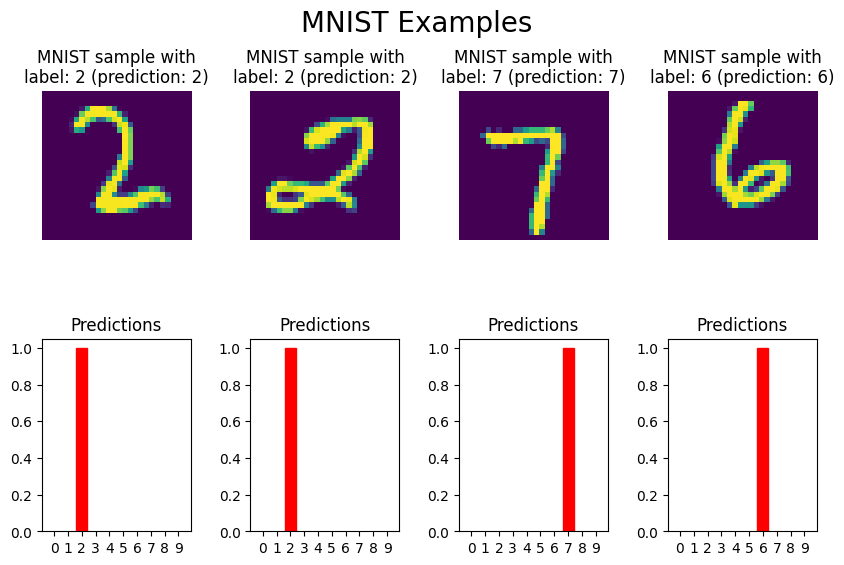

In [ ]:
# Get a batch of test samples from each data handler.
mnist_inps, mnist_trgts = mnist.next_test_batch(4)

# Compute predictions for test batches above.
with torch.no_grad():
    mnist_X = mnist.input_to_torch_tensor(mnist_inps, device, mode='inference')
    
    W_mnist = hnet(cond_id=0)
    mnist_preds = mnet.forward(mnist_X, weights=W_mnist)
    
    # Note, the network outputs are logits, and thus not normalized.
    mnist_preds = torch.softmax(mnist_preds, dim=1)
    mnist_preds = mnist_preds.detach().cpu().numpy()

mnist.plot_samples('MNIST Examples', mnist_inps, outputs=mnist_trgts,
                   predictions=mnist_preds)